**Xception transfer learning**

# DATASET: Stanford Dogs
The Stanford Dogs dataset contains images of 120 breeds of dogs from around the world.

###**1. Import libraries**

In [ ]:
import os
import pandas as pd

import xml.etree.ElementTree as ET
import time
import math
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential

from keras.utils import np_utils
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.xception import decode_predictions
%matplotlib inline
from sklearn.metrics import classification_report

from PIL import Image
import matplotlib.image as mpimg
from imgaug import augmenters as iaa

###**2. Connect to Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###**3. Define paths and labels**

In [ ]:
#define dataset path
image_path = '/content/drive/MyDrive/Project FindPet/dataset/StanfordDataset/original/Images'
# Number of classes in the dataset
num_of_categories = 120
# Image size input (299x299)
image_size = 299
# Batch size for training
batch_size = 16

In [ ]:
#list of breeds
breed_list = sorted(os.listdir(image_path))
#number of classes
num_classes = len(breed_list)
print("{} breeds".format(num_classes))

120 breeds


In [ ]:
# Define a time counter function to test the algorythms performance 
_start_time = time.time()

def process_time_starts():
    global _start_time 
    _start_time = time.time()

def time_elapsed():
    t_sec = round(time.time() - _start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print('The process took: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))

###**4. Generate a data folder with cropped pictures**

In [ ]:
path= '/content/drive/MyDrive/Project FindPet/dataset/StanfordDataset/'
#Create a new folder to save cropeed images
os.mkdir(path+'data')
for breed in breed_list:
    #Create subfolders with the same breed names
    os.mkdir(path+'data/' + breed)
print('Created {} folders to store cropped images of the different breeds.'.format(len(os.listdir(path+'data'))))

In [ ]:
%%time
for breed in os.listdir(path + 'data'):
    for file in os.listdir(path +'original/Annotation/{}'.format(breed)):
        img = Image.open(path + 'original/Images/{}/{}.jpg'.format(breed, file)) #Open the image 
        tree = ET.parse(path +'original/Annotation/{}/{}'.format(breed, file)) #Parsing the XML annotation that includes the bounding box
        xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text) #Reading xmin border coordinate
        xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text) #Reading xman coordinate
        ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text) #Reading ymin coordinate
        ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text) #Reading ymax coordinate
        img = img.crop((xmin, ymin, xmax, ymax)) #Crop image based in bounding box
        img = img.convert('RGB')  #Convert from BGR to RGB
        img = img.resize((image_size, image_size)) #Resize image 299x299
        img.save(path + 'data/' + breed + '/' + file + '.jpg') #Save image into the new folder

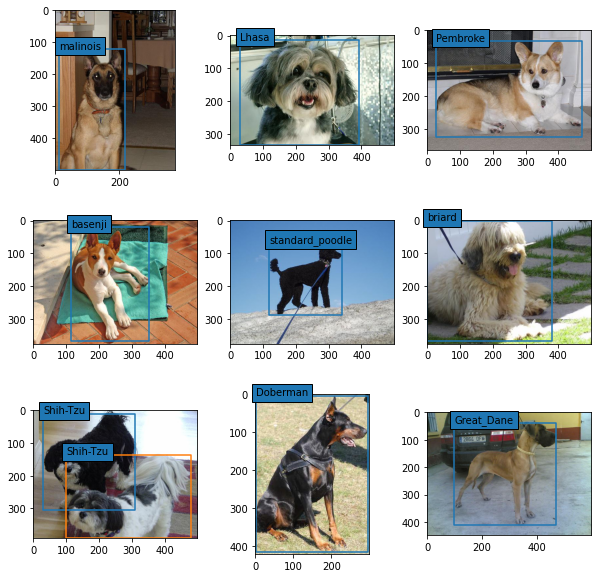

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(331 + i) # showing 9 random images
    breed = np.random.choice(breed_list) # random breed
    dog = np.random.choice(os.listdir(path + 'original/Annotation/' + breed)) # random image 
    img = Image.open(path + 'original/Images/' + breed + '/' + dog + '.jpg') 
    tree = ET.parse(path + 'original/Annotation/' + breed + '/' + dog) # init parser for file given
    root = tree.getroot() 
    objects = root.findall('object') # finding all dogs. An array
    plt.imshow(img) # displays photo
    for o in objects:
        bndbox = o.find('bndbox') # reading border coordinates
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin]) # showing border
        plt.text(xmin, ymin, o.find('name').text, bbox={'ec': None}) 

###**5. Define paths (X) and labels (y)**

In [ ]:
#Define dictionary of labels based on index
label_maps = {}
label_maps_rev = {}
for i, v in enumerate(breed_list):
    label_maps.update({v: i})
    label_maps_rev.update({i : v})

In [ ]:
def paths_and_labels():
    paths = list()   #list of image paths
    labels = list()  #list of name of breeds
    targets = list() #list of index of breed
    for breed in breed_list:
        base_name = path + "data/{}/".format(breed)
        for img_name in os.listdir(base_name):
            paths.append(base_name + img_name)
            labels.append(breed) 
            targets.append(label_maps[breed])
    return paths, labels, targets

#Get list of image paths, labels and targets
paths, labels, targets = paths_and_labels()

assert len(paths) == len(labels)
assert len(paths) == len(targets)

#Converts integer targets to binary class matrix
targets = np_utils.to_categorical(targets, num_classes=num_classes)

###**6. Define image generator with custom augmentation**

In [ ]:
class ImageGenerator(Sequence):
    
    def __init__(self, paths, targets, batch_size, shape, augment=False):
        self.paths = paths
        self.targets = targets
        self.batch_size = batch_size
        self.shape = shape
        self.augment = augment
        
    def __len__(self):
        return int(np.ceil(len(self.paths) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        batch_paths = self.paths[idx * self.batch_size : (idx + 1) * self.batch_size]
        x = np.zeros((len(batch_paths), self.shape[0], self.shape[1], self.shape[2]), dtype=np.float32)
        y = np.zeros((self.batch_size, num_classes, 1))
        for i, path in enumerate(batch_paths):
            x[i] = self.__load_image(path)
        y = self.targets[idx * self.batch_size : (idx + 1) * self.batch_size]
        return x, y
    
    def __iter__(self):
        for item in (self[i] for i in range(len(self))):
            yield item
            
    def __load_image(self, path):
        image = cv2.imread(path)
        image = preprocess_input(image)
        if self.augment:
            seq = iaa.Sequential([
                iaa.OneOf([ # Apply one of three augmenters to each image
                    iaa.Fliplr(0.5),  # horizontally flip 50% of images
                    iaa.Flipud(0.5),  # vertically flip 50% of images
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, #Scale images to a value of 80 to 120% of their original size, but do this independently per axis
                        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, #Translate images by -20 to 20 % on x- and y-axis independently
                        rotate=(-40, 40), #Rotate images by -40 to 40 degrees
                        shear=(-8, 8) #Shear images by -8 to 8 degrees
                    )
                ])
            ], random_order=True) # apply the augmentations in random order
            image = seq.augment_image(image)
        return image

###**7. Split X and Y into train, validation and test**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(paths, targets, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=1)

train_ds = ImageGenerator(x_train, y_train, batch_size=32, shape=(image_size, image_size,3), augment=True)
val_ds = ImageGenerator(x_test, y_test, batch_size=32, shape=(image_size, image_size,3), augment=False)
test_ds = ImageGenerator(x_test, y_test, batch_size=32, shape=(image_size, image_size,3), augment=False)


###**8. MODEL PREPARATION**



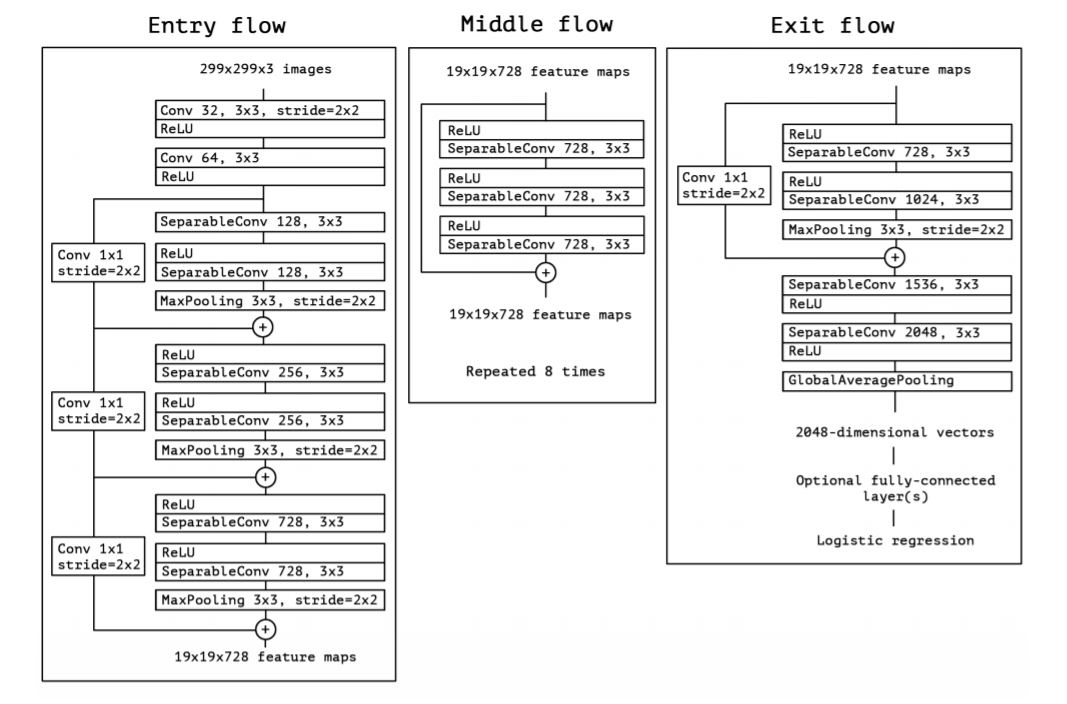

###**8.1 Importing the Xception CNN**

In [ ]:
#xception model using pre-trained weights of imagenet
#include_top is False to not include the fully connected layer on top of the network
base_model = tf.keras.applications.xception.Xception(weights='imagenet',include_top=False, pooling='avg')
#to only update the params of the new layers
base_model.trainable = False

###**8.2 Add Fully connected layers**

In [ ]:
flat_dim = 5 * 5 * 2048
# Create a 'Sequential' model
my_model = Sequential(base_model)
#Add 3 Dense layers with relu activation function
my_model.add(Dense(1032, activation='relu',input_dim=flat_dim))
my_model.add(Dense(512, activation='relu'))
my_model.add(Dense(256, activation='relu'))
#Add Dense layer with softmax activation function
my_model.add(Dense(120, activation='softmax'))

###**8.3 Define callbacks and compile the model**

[1e-05, 6.505114555849587e-06, 1.3998974074878144e-05, 2.1158257692363077e-05, 2.6349806140466085e-05, 2.9032781503571898e-05, 2.9396559030789573e-05, 2.7979491786027585e-05, 2.540182222438155e-05, 2.2217993076484613e-05, 1.885603456913674e-05, 1.5609303737669377e-05, 1.265427690063973e-05, 1.0077640616334645e-05, 7.903437440340427e-06, 6.116030942221757e-06, 4.677609611772819e-06, 3.5404805065519026e-06, 2.655051675737932e-06, 1.9745568653868732e-06, 1.457488127964179e-06, 1.068520029068309e-06, 7.785125464502897e-07, 5.640054703120814e-07, 4.0647805168961314e-07]


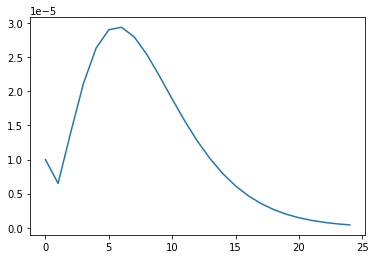

In [ ]:
###################
total_epoch = 8
learning_rate_init = 0.00001
###################

#learning rate variable
def lr_scheduler(epoch):
    epoch += 1
   
    if epoch == 1:
        return learning_rate_init
    
    elif epoch >= 2 and epoch <= 40:
        return (0.2*epoch**3)*math.exp(-0.45*epoch)*learning_rate_init
    
    else:
        return lr_scheduler(40-1)
    

stage = [i for i in range(0,25)]
learning_rate = [lr_scheduler(x) for x in stage]
plt.plot(stage, learning_rate)
print(learning_rate)

In [ ]:
# Callbacks

scheduler = keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience = 6, mode='max', min_delta=1, verbose=1)

In [ ]:
#Configures the model for training with adam optimizer
my_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


###**9. TRAINING THE MODEL**



In [ ]:
process_time_starts()

hist = my_model.fit_generator(generator=train_ds, steps_per_epoch=400, validation_data=val_ds,  validation_steps=90, epochs=8, callbacks=[scheduler])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/8

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
400/400 [==============================] - 4840s 12s/step - loss: 4.6441 - accuracy: 0.1381 - val_loss: 4.3849 - val_accuracy: 0.3431
Epoch 2/8

Epoch 00002: LearningRateScheduler reducing learning rate to 6.505114555849587e-06.
400/400 [==============================] - 650s 2s/step - loss: 4.1918 - accuracy: 0.3664 - val_loss: 3.8475 - val_accuracy: 0.4865
Epoch 3/8

Epoch 00003: LearningRateScheduler reducing learning rate to 1.3998974074878144e-05.
400/400 [==============================] - 229s 573ms/step - loss: 3.2205 - accuracy: 0.5045 - val_loss: 2.2984 - val_accuracy: 0.6448
Epoch 4/8

Epoch 00004: LearningRateScheduler reducing learning rate to 2.1158257692363077e-05.
400/400 [==============================] - 162s 404ms/step - loss: 1.8387 - accuracy: 0.6493 - val_loss: 1.1174 - val_accuracy: 0.7688
Epoch 5/8

Epoch 00005: LearningRateScheduler reducing learning rate to 2.6349806140466085e-05.
40

In [ ]:
time_elapsed()

The process took: 1hour:54min:14sec


###**10. LOSS AND ACCURACY VISUALIZATION**

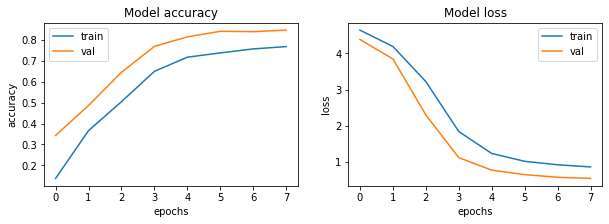

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])


###**11. Save model and parameters**

In [ ]:
my_model.save('my_model.h5', overwrite=True) 
my_model.save_weights('dog_breed_xcept_weights.h5', overwrite=True)
print("Saved model to disk")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Saved model to disk


###**12. Test model accuracy**

In [ ]:
test_loss, test_accuracy = my_model.evaluate_generator(generator=test_ds,steps=int(100))

print("Test results \n Loss:",test_loss,'\n Accuracy',test_accuracy)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test results 
 Loss: 0.5506390929222107 
 Accuracy 0.8415625095367432


###**13. Predict new images**

In [ ]:
def download_and_predict(url, filename):
    # download and save
    os.system("curl -s {} -o {}".format(url, filename))
    img = Image.open(filename)
    img = img.convert('RGB')
    img = img.resize((299, 299))
    img.save(filename)
    # show image
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    # predict
    img = image.imread(filename)
    img = preprocess_input(img)
    probs = my_model.predict(np.expand_dims(img, axis=0))
    for idx in probs.argsort()[0][::-1][:5]:
        print("{:.2f}%".format(probs[0][idx]*100), "\t", label_maps_rev[idx].split("-")[-1])

86.25% 	 malinois
3.07% 	 German_shepherd
1.87% 	 Ibizan_hound
1.45% 	 Doberman
1.19% 	 dhole


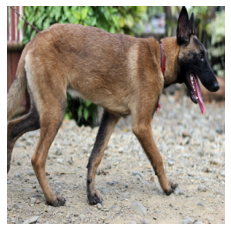

In [ ]:
download_and_predict("https://cdn.pixabay.com/photo/2018/08/12/02/52/belgian-mallinois-3599991_1280.jpg",
                     "test_1.jpg")